In [1]:
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
# import json
# from torch.utils.data import Dataset, DataLoader
# import transformers
from transformers import RobertaModel, RobertaTokenizer, RobertaForMultipleChoice
from torch import cuda
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# load data
test_raw_data = pd.read_json('data/test.jsonl', lines=True)
dev_raw_data = pd.read_json('data/dev.jsonl', lines=True)
train_raw_data = pd.read_json('data/train.jsonl', lines=True)
train_raw_data.head(10)

,premise,choice1,choice2,question,label,idx
0,My body cast a shadow over the grass.,The sun was rising.,The grass was cut.,cause,0,0
1,The woman tolerated her friend's difficult beh...,The woman knew her friend was going through a ...,The woman felt that her friend took advantage ...,cause,0,1
2,The women met for coffee.,The cafe reopened in a new location.,They wanted to catch up with each other.,cause,1,2
3,The runner wore shorts.,The forecast predicted high temperatures.,She planned to run along the beach.,cause,0,3
4,The guests of the party hid behind the couch.,It was a surprise party.,It was a birthday party.,cause,0,4
5,The politician lost the election.,He ran negative campaign ads.,No one voted for him.,cause,1,5
6,The stain came out of the shirt.,I patched the shirt.,I bleached the shirt.,cause,1,6
7,The man got a discount on his groceries.,He greeted the cashier.,He used a coupon.,cause,1,7
8,The physician misdiagnosed the patient.,The patient filed a malpractice lawsuit agains...,The patient disclosed confidential information...,effect,0,8
9,The customer filed a complaint with the store ...,The sales associate undercharged the customer.,The sales associate acted rude to the customer.,cause,1,9


In [4]:
# test
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# test_sequence = "{" + "effect" + "}" + "I ran the ice cube under warm water."
test_sequence = "{"+ test_raw_data.iloc[28]['question'] + "}" + test_raw_data.iloc[28]['premise']
print("test_sequence is: ", test_sequence)
print(tokenizer(test_sequence))
print(tokenizer.tokenize(test_sequence))
# test 2
test_sequence = "{"+ test_raw_data.iloc[1]['question'] + "}" + test_raw_data.iloc[1]['premise']
print("test_sequence is: ", test_sequence)
print(tokenizer(test_sequence))
print(tokenizer.tokenize(test_sequence))

print(test_raw_data.shape[0])

test_sequence is:  {effect}The girl refused to eat her vegetables.
{'input_ids': [0, 45152, 26715, 24303, 133, 1816, 3179, 7, 3529, 69, 8942, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['{', 'effect', '}', 'The', 'Ġgirl', 'Ġrefused', 'Ġto', 'Ġeat', 'Ġher', 'Ġvegetables', '.']
test_sequence is:  {effect}The girl found a bug in her cereal.
{'input_ids': [0, 45152, 26715, 24303, 133, 1816, 303, 10, 13673, 11, 69, 25629, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['{', 'effect', '}', 'The', 'Ġgirl', 'Ġfound', 'Ġa', 'Ġbug', 'Ġin', 'Ġher', 'Ġcereal', '.']
100


In [5]:
def load_data(rawdata):
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # for i in range(0, rawdata.shape[0]):
    for i in range(2, 5):
        prompt = rawdata.iloc[i]['question'] + "." + rawdata.iloc[i]['premise']
        choice0 = rawdata.iloc[i]['choice1']
        choice1 = rawdata.iloc[i]['choice2']
        label = torch.tensor(rawdata.iloc[i]['label'])
        # label = torch.tensor(rawdata.iloc[i]['label']).unsqueeze(0).to(device)

        encoding = tokenizer([prompt, prompt], [choice0, choice1], return_tensors='pt', padding=True)
        print("encoding['input_ids']: ", encoding['input_ids'])
        print("encoding['input_ids'] with size of : ", encoding['input_ids'].size())
        print("encoding['attention_mask']: ", encoding['attention_mask'])
        print("label: ", label)
    return encoding

In [6]:
print(train_raw_data.shape[0])
print(dev_raw_data.shape[0])
print(test_raw_data.shape[0])

350
50
100


In [7]:
# tokenize data tests
train_data = load_data(train_raw_data)
# print(f'Training data loaded (length {len(train_data)})')
# dev_data = load_data('data/dev.jsonl')
# print(f'Dev data loaded (length {len(dev_data)})')
# test_data = load_data('data/test.jsonl')
# print(f'Test data loaded (length {len(test_data)})')

encoding['input_ids']:  tensor([[    0, 27037,     4,   133,   390,  1145,    13,  3895,     4,     2,
             2,   133, 16381, 14015,    11,    10,    92,  2259,     4,     2,
             1],
        [    0, 27037,     4,   133,   390,  1145,    13,  3895,     4,     2,
             2,  1213,   770,     7,  2916,    62,    19,   349,    97,     4,
             2]])
encoding['input_ids'] with size of :  torch.Size([2, 21])
encoding['attention_mask']:  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
label:  tensor(1)
encoding['input_ids']:  tensor([[    0, 27037,     4,   133,  7449,  5328, 13344,     4,     2,     2,
           133,  1914,  6126,   239,  3971,     4,     2,     1,     1],
        [    0, 27037,     4,   133,  7449,  5328, 13344,     4,     2,     2,
          2515,  1904,     7,   422,   552,     5,  4105,     4,     2]])
encoding['input_ids'] with size of :  torch.

## Model Construction

In [8]:
# Model_3, use only the very last hidden layer from Roberta.
from torch import nn
from transformers import RobertaConfig, RobertaModel

class OurRobertaCOPA(torch.nn.Module):
    def __init__(self):
        super(OurRobertaCOPA, self).__init__()
        # self.configuration = RobertaConfig()
        # self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        # self.l1 = RobertaModel(self.configuration)
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.l1.requires_grad = True
        self.softmax = nn.Softmax(dim=0)
        self.pre_classifier = torch.nn.Linear(768, 512)
        self.dropout = torch.nn.Dropout(0.3)
        # self.classifier = torch.nn.Linear(768, 5)
        # hidden_dim=32 for later trials.
        # self.lstm = nn.LSTM(768, 32, 1, bias=False)
        self.output_layer = nn.Linear(512, 2)

    def forward(self, sequence_1, sequence_2):
        # Two input here
        token_1 = tokenizer(sequence_1)
        token_2 = tokenizer(sequence_2)
        output_1 = self.l1(input_ids=torch.tensor(token_1["input_ids"]).unsqueeze(0), attention_mask=torch.tensor(token_1["attention_mask"]).unsqueeze(0))[0]
        output_2 = self.l1(input_ids=torch.tensor(token_2["input_ids"]).unsqueeze(0), attention_mask=torch.tensor(token_2["attention_mask"]).unsqueeze(0))[0]
        # RobertaModel(RobertaConfig())

        # _, (hidden_rep_1, _) = self.lstm(output_1.unsqueeze(0))
        # _, (hidden_rep_2, _) = self.lstm(output_2.unsqueeze(0))
        # _, (hidden_rep_1, _) = self.lstm(output_1)
        # _, (hidden_rep_2, _) = self.lstm(output_2)

        hidden_rep_1 = torch.nn.ReLU()(self.pre_classifier(output_1[0])).squeeze(0)
        hidden_rep_2 = torch.nn.ReLU()(self.pre_classifier(output_2[0])).squeeze(0)
        pooler_1 = hidden_rep_1[:, 0]
        pooler_2 = hidden_rep_2[:, 0]
        # hidden_rep_1 = self.pre_classifier(output_1[0]).squeeze(0)
        # hidden_rep_2 = self.pre_classifier(output_2[0]).squeeze(0)
        # print("-------hidden_rep_1:")
        # print(hidden_rep_1)
        # print(hidden_rep_1.size())
        # print("-------hidden_rep_2:")
        # print(hidden_rep_2)
        # print(hidden_rep_2.size())
        
        # hidden_rep = torch.cat((hidden_rep_1.unsqueeze(1), hidden_rep_2.unsqueeze(1)), 1)
        # hidden_rep = self.dropout(torch.cat((hidden_rep_1, hidden_rep_2), 0))
        hidden_rep = self.dropout(torch.cat((pooler_1, pooler_2), 0))

        print("-------hidden_rep:")
        # print(hidden_rep)
        print(hidden_rep.size())

        output = self.output_layer(hidden_rep.unsqueeze(0))
        print("-------output:")
        # print(output)
        print(output.size())
        print("--------------")

        output_squezzed = output.squeeze(0).squeeze(0)
        print("-------output_squezzed:")
        print(output_squezzed)
        print(output_squezzed.size())
        print("--------------")
        
        # y_hat = softmax(output_squezzed)
        # y_sum =  torch.sum(y_hat, 0)
        # col1= torch.sum(y_hat, 0)[0]
        # col2 = torch.sum(y_hat, 0)[1]
        # y_result = torch.tensor(torch.argmax(y_sum)).type(torch.FloatTensor)
        # y_result = torch.tensor(y_sum)
        
        return output_squezzed

## Training

In [9]:
# Initialization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = OurRobertaCOPA()
model = RobertaForMultipleChoice.from_pretrained('roberta-base')
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultipleChoice: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

RobertaForMultipleChoice(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [18]:
ce = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
per_num_epoch = 1

# train_acc = np.zeros(epochs)
train_loss_by_epoch = np.zeros(epochs)
dev_acc = np.zeros(epochs)
dev_loss_by_epoch = np.zeros(epochs)

start_time = datetime.now()

for j in range(epochs):
    if j % per_num_epoch == 0:
        print('--------------Epoch: ' + str(j+1) + '--------------')
    
    if j % per_num_epoch == 0:
        print(f'Training for epoch {j + 1}.......')
    
    av_train_loss = 0
    # print("av_train_loss_original: ", av_train_loss)
    model.train()
    for i in range(0, train_raw_data.shape[0]):
        # print("av_train_loss_track: ", av_train_loss)
        prompt = train_raw_data.iloc[i]['question'] + ". " + train_raw_data.iloc[i]['premise']
        choice0 = train_raw_data.iloc[i]['choice1']
        choice1 = train_raw_data.iloc[i]['choice2']
        label = torch.tensor(train_raw_data.iloc[i]['label']).unsqueeze(0).to(device)
        # print("label is: ", label)

        encoding = tokenizer([prompt, prompt], [choice0, choice1], return_tensors='pt', padding=True).to(device)
        # outputs = model(input_ids=encoding['input_ids'].unsqueeze(0), attention_mask=encoding['attention_mask'].unsqueeze(0), labels=label)
        outputs = model(**{k: v.unsqueeze(0) for k,v in encoding.items()}, labels=label)
        
        train_loss = outputs.loss
        train_logits = outputs.logits
        av_train_loss += train_loss

        if i == 0:
            print("train_loss: ", train_loss)
            print("train_logits: ", train_logits)
            print("label: ", label)
        if i == 1:
            print("train_loss: ", train_loss)
            print("train_logits: ", train_logits)
            print("label: ", label)

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        # learning rate decay
        # if j == 25:
        #     optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        # elif j == 50:
        #     optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

    train_loss_by_epoch[j] = av_train_loss / train_raw_data.shape[0]
    print("av_train_loss: ", train_loss_by_epoch[j])

    # validation
    # if (j + 1) % per_num_epoch == 0:
    #     print(f'.......Validating for epoch {j + 1}')
    if (j) % per_num_epoch == 0:
        print(f'.......Validating for epoch {j + 1}')
        av_dev_loss = 0
        model.eval()
        with torch.no_grad():
            for i in range(0, dev_raw_data.shape[0]):
                # print("av_dev_loss_track: ", av_dev_loss)
                prompt = dev_raw_data.iloc[i]['question'] + ". " + dev_raw_data.iloc[i]['premise']
                choice0 = dev_raw_data.iloc[i]['choice1']
                choice1 = dev_raw_data.iloc[i]['choice2']
                label = torch.tensor(dev_raw_data.iloc[i]['label']).unsqueeze(0).to(device)

                encoding = tokenizer([prompt, prompt], [choice0, choice1], return_tensors='pt', padding=True).to(device)
                # outputs = model(input_ids=encoding['input_ids'].unsqueeze(0), attention_mask=encoding['attention_mask'].unsqueeze(0), labels=label)
                outputs = model(**{k: v.unsqueeze(0) for k,v in encoding.items()}, labels=label)
                
                dev_loss = outputs.loss
                dev_logits = outputs.logits
                av_dev_loss += dev_loss
                
                if i == 0:
                    print("dev_loss: ", dev_loss)
                    print("dev_logits: ", dev_logits)
                    print("label: ", label)
                if i == 1:
                    print("dev_loss: ", dev_loss)
                    print("dev_logits: ", dev_logits)
                    print("label: ", label)

                #calculate accuracy
                y_pred = 1 if outputs.logits[0][1] > outputs.logits[0][0] else 0
                y_pred = torch.tensor(y_pred).unsqueeze(0).to(device)
                # print("y_pred: ", y_pred)
                # print("label: ", label)
                # print("y_pred =? label: ", y_pred == label)
                if y_pred == label:
                    dev_acc[j] += 1
                # print("dev_acc[j]: ", dev_acc[j])

        dev_acc[j] /= dev_raw_data.shape[0]
        dev_loss_by_epoch[j] = av_dev_loss / dev_raw_data.shape[0]

end_time = datetime.now()
print(f'Training completed in {str(end_time - start_time)}')

--------------Epoch: 1--------------
Training for epoch 1.......
train_loss:  tensor(4.3557, device='cuda:0', grad_fn=<NllLossBackward0>)
train_logits:  tensor([[-7.3646, -3.0218]], device='cuda:0', grad_fn=<ViewBackward0>)
label:  tensor([0], device='cuda:0')
train_loss:  tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward0>)
train_logits:  tensor([[ 3.3072, -0.9613]], device='cuda:0', grad_fn=<ViewBackward0>)
label:  tensor([0], device='cuda:0')


KeyboardInterrupt: 

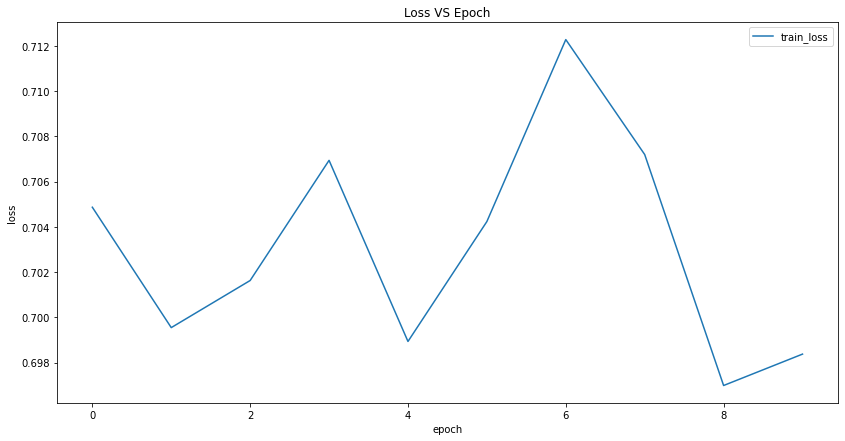

In [11]:
# plot
plt.figure(figsize=(14, 7))
plt.title("Loss VS Epoch")

plt.plot(train_loss_by_epoch, label="train_loss")
# plt.plot(dev_loss_by_epoch, label="dev_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

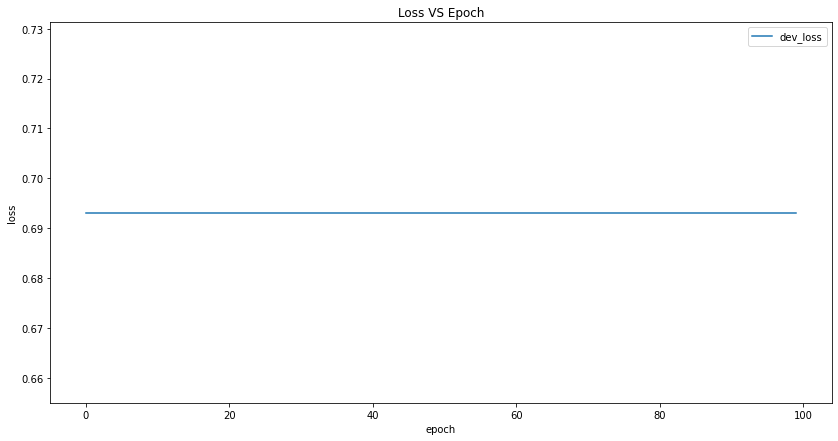

In [41]:
# plot
plt.figure(figsize=(14, 7))
plt.title("Loss VS Epoch")

plt.plot(dev_loss_by_epoch, label="dev_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [41]:
# save the model
torch.save(model, 'RoBERTa.pth')# epochs = 10, lr=1e-1 ->25:1e-3 ->50:1e-6

## Testing

In [42]:
test_model = torch.load('RoBERTa.pth')

In [46]:
test_model.eval()
num_correct_pred = 0

with torch.no_grad():
    for i in range(0, test_raw_data.shape[0]):
        prompt = test_raw_data.iloc[i]['question'] + ". " + test_raw_data.iloc[i]['premise']
        choice0 = test_raw_data.iloc[i]['choice1']
        choice1 = test_raw_data.iloc[i]['choice2']
        label = torch.tensor(test_raw_data.iloc[i]['label']).unsqueeze(0).to(device)

        encoding = tokenizer([prompt, prompt], [choice0, choice1], return_tensors='pt', padding=True).to(device)
        outputs = test_model(input_ids=encoding['input_ids'].unsqueeze(0), attention_mask=encoding['attention_mask'].unsqueeze(0), labels=label)

        test_logits = outputs.logits

        #calculate accuracy
        y_pred = 1 if outputs.logits[0][1] > outputs.logits[0][0] else 0
        y_pred = torch.tensor(y_pred).unsqueeze(0).to(device)

        if y_pred == label:
            print("test_logits: ", test_logits)
            print("y_pred: ", y_pred)
            print("label: ", label)
            num_correct_pred += 1

acc = num_correct_pred / test_raw_data.shape[0]
print("test_accuracy = ", acc)

test_logits:  tensor([[1193.0547, 1193.0547]], device='cuda:0')
y_pred:  tensor([0], device='cuda:0')
label:  tensor([0], device='cuda:0')
test_logits:  tensor([[1193.0547, 1193.0547]], device='cuda:0')
y_pred:  tensor([0], device='cuda:0')
label:  tensor([0], device='cuda:0')
test_logits:  tensor([[1193.0547, 1193.0547]], device='cuda:0')
y_pred:  tensor([0], device='cuda:0')
label:  tensor([0], device='cuda:0')
test_logits:  tensor([[1193.0547, 1193.0547]], device='cuda:0')
y_pred:  tensor([0], device='cuda:0')
label:  tensor([0], device='cuda:0')
test_logits:  tensor([[1193.0547, 1193.0547]], device='cuda:0')
y_pred:  tensor([0], device='cuda:0')
label:  tensor([0], device='cuda:0')
test_logits:  tensor([[1193.0547, 1193.0547]], device='cuda:0')
y_pred:  tensor([0], device='cuda:0')
label:  tensor([0], device='cuda:0')
test_logits:  tensor([[1193.0547, 1193.0547]], device='cuda:0')
y_pred:  tensor([0], device='cuda:0')
label:  tensor([0], device='cuda:0')
test_logits:  tensor([[1193

In [21]:
# Revise
# Training
ce = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
per_num_epoch = 1

# train_acc = np.zeros(epochs)
train_loss_by_epoch = np.zeros(epochs)
dev_acc = np.zeros(epochs)
dev_loss_by_epoch = np.zeros(epochs)

start_time = datetime.now()

for j in range(epochs):
    if j % per_num_epoch == 0:
        print('--------------Epoch: ' + str(j+1) + '--------------')
    
    if j % per_num_epoch == 0:
        print(f'Training for epoch {j + 1}.......')
    av_train_loss = 0
    # print("av_train_loss_original: ", av_train_loss)
    model.train()
    for i in range(0, train_raw_data.shape[0]):
        # print("av_train_loss_track: ", av_train_loss)
        prompt = train_raw_data.iloc[i]['question'] + ". " + train_raw_data.iloc[i]['premise']
        choice0 = train_raw_data.iloc[i]['choice1']
        choice1 = train_raw_data.iloc[i]['choice2']
        label = torch.tensor(train_raw_data.iloc[i]['label']).unsqueeze(0).to(device)
        # print("label is: ", label)
        # label = torch.tensor(rawdata.iloc[i]['label']).unsqueeze(0).to(device)

        encoding = tokenizer([prompt, prompt], [choice0, choice1], return_tensors='pt', padding=True).to(device)
        # outputs = model(input_ids=encoding['input_ids'].unsqueeze(0), attention_mask=encoding['attention_mask'].unsqueeze(0), labels=label)
        optimizer.zero_grad()
        outputs = model(**{k: v.unsqueeze(0) for k,v in encoding.items()}, labels=label)
        
        train_loss = outputs.loss
        train_logits = outputs.logits
        av_train_loss += train_loss

        if i == 0:
            print("train_loss: ", train_loss)
            print("train_logits: ", train_logits)
            print("label: ", label)
        if i == 1:
            print("train_loss: ", train_loss)
            print("train_logits: ", train_logits)
            print("label: ", label)

        train_loss.backward()

        optimizer.step()

        # learning rate decay
        # if j == 25:
        #     optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        # elif j == 50:
        #     optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
        
        # 

    train_loss_by_epoch[j] = av_train_loss / train_raw_data.shape[0]
    print("av_train_loss: ", train_loss_by_epoch[j])

end_time = datetime.now()
print(f'Training completed in {str(end_time - start_time)}')


--------------Epoch: 1--------------
Training for epoch 1.......
train_loss:  tensor(11.3468, device='cuda:0', grad_fn=<NllLossBackward0>)
train_logits:  tensor([[ 3.5860, 14.9327]], device='cuda:0', grad_fn=<ViewBackward0>)
label:  tensor([0], device='cuda:0')
train_loss:  tensor(0.7526, device='cuda:0', grad_fn=<NllLossBackward0>)
train_logits:  tensor([[11.2423, 11.3579]], device='cuda:0', grad_fn=<ViewBackward0>)
label:  tensor([0], device='cuda:0')
av_train_loss:  3.2429466247558594
--------------Epoch: 2--------------
Training for epoch 2.......
train_loss:  tensor(0., device='cuda:0', grad_fn=<NllLossBackward0>)
train_logits:  tensor([[12.2284, -8.9319]], device='cuda:0', grad_fn=<ViewBackward0>)
label:  tensor([0], device='cuda:0')
train_loss:  tensor(0., device='cuda:0', grad_fn=<NllLossBackward0>)
train_logits:  tensor([[13.1985, -6.4186]], device='cuda:0', grad_fn=<ViewBackward0>)
label:  tensor([0], device='cuda:0')
av_train_loss:  3.509030342102051
--------------Epoch: 3--